# Finding the Elasticity Matrix of a Shell with a Microstructure - Ribbed Plates

We use asymptotic homogenization theory to find the equivalent elastic stiffness matrix of a shell with a ribbed microstructure.

In [21]:
lx = 1  # length of the side parallel to the x axis
ly = 1  # length of the side parallel to the y axis
t = 0.2  # thickness of the plate

wx = 0.2  # width of the beams running parallel to x
hx = 0.5  # height of the beams running parallel to x
ex = 0.01  # excentricity of the beams running parallel to x

wy = 0.2  # width of the beams running parallel to x
hy = 0.5  # height of the beams running parallel to x
ey = -0.01  # excentricity of the beams running parallel to x

lmax = None  # maximum edge length, Optional
order = 2  # order of the polygons in the mesh
tetrahedralize = False  # if the mesh should be made up from tetrahedra
use_tetgen = True  # to use tetgen for tetrahedralization or not

plot_to_image = True  # plot to image or show a widget


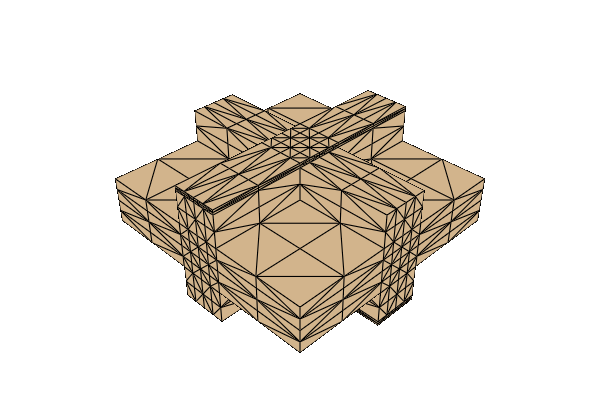

In [22]:
from polymesh.recipes import ribbed_plate

mesh = ribbed_plate(lx=lx, ly=ly, t=t,
                    wx=wx, hx=hx, ex=ex,
                    wy=wy, hy=hy, ey=ey,
                    lmax=lmax, order=order,
                    tetrahedralize=tetrahedralize)

mesh.plot(notebook=True, jupyter_backend='static',
          window_size=(600, 400))


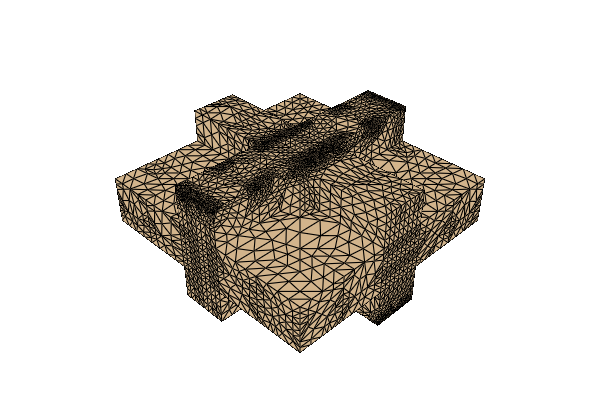

In [23]:
from polymesh import tetrahedralize

if use_tetgen:
    mesh = tetrahedralize(mesh, order=order, mindihedral=10,
                          minratio=1.5, quality=True,
                          steinerleft=-1)

    mesh.plot(notebook=True, jupyter_backend='static',
              window_size=(600, 400))


In [24]:
import numpy as np
from polymesh import PointData, CartesianFrame
from sigmaepsilon.fem.cells import H8, H27, TET4, TET10
from sigmaepsilon import PointData, SolidMesh as Mesh

E = 5000.  # Young's mpdulus
nu = 0.2  # Poisson's ratio
A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))

GlobalFrame = CartesianFrame(dim=3)
coords = mesh.coords()
topo = mesh.topology()
pd = PointData(coords=coords, frame=GlobalFrame)
if topo.shape[1] == 4:
    cd = TET4(topo=topo, frames=GlobalFrame, material=A)
elif topo.shape[1] == 8:
    cd = H8(topo=topo, frames=GlobalFrame, material=A)
elif topo.shape[1] == 10:
    cd = TET10(topo=topo, frames=GlobalFrame, material=A)
elif topo.shape[1] == 27:
    cd = H27(topo=topo, frames=GlobalFrame, material=A)
mesh = Mesh(pd, cd, frame=GlobalFrame)


In [25]:
from sigmaepsilon.material import RepresentativeSurfaceElement as RSE

rse = RSE(mesh=mesh)
hooke = rse.ABDS()

In [26]:
import pandas as pd

pd.DataFrame(hooke)

,0,1,2,3,4,5,6,7
0,1328.375149,188.438814,0.010375,4.378543,-0.037673,0.021251,0.000000,0.00000
1,188.438814,1329.780811,-0.137047,0.018834,-4.406345,-0.017550,0.000000,0.00000
2,0.010375,-0.137047,478.400278,0.028402,0.004866,0.004717,0.000000,0.00000
3,4.345145,0.013235,0.027195,13.706587,1.110805,0.003211,0.000000,0.00000
4,-0.042121,-4.385676,0.003571,1.109660,13.721555,0.002216,0.000000,0.00000
5,0.019794,-0.014412,-0.004234,0.004709,0.004215,3.459469,0.000000,0.00000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,533.639383,0.00165
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001650,533.42344


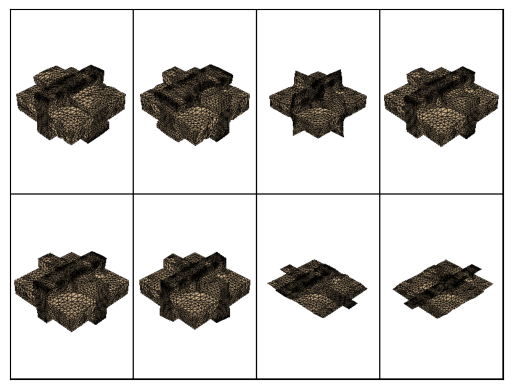

In [27]:
import pyvista as pv
import matplotlib.pyplot as plt

N = hooke.shape[-1]
dofsol = rse.nodal_dof_solution()

plotter = pv.Plotter(shape=(2, int(N/2)), window_size=(800, 600),
                     off_screen=plot_to_image, notebook=False)
c = 0
for i in range(2):
    for j in range(int(N/2)):
        plotter.subplot(i, j)
        rse.mesh.pd['x'] = coords + dofsol[:, :3, c]
        mesh.pvplot(notebook=False, plotter=plotter, return_plotter=True)
        c += 1

if not plot_to_image:
    plotter.show()
else:
    fig = plt.imshow(plotter.screenshot())
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
